In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import re

In [37]:
# load data.csv file
df = pd.read_csv('/content/twitter_training.csv')
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [38]:
df.columns

Index(['2401', 'Borderlands', 'Positive',
       'im getting on borderlands and i will murder you all ,'],
      dtype='object')

In [39]:
# Rename columns
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'tweets', 'Positive': 'label'})
df.head()

,2401,Borderlands,label,tweets
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


In [40]:
# Drop unwanted columns
df.drop(columns=['2401','Borderlands'],inplace=True)
df.head()

,label,tweets
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...


In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74681 entries, 0 to 74680
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   74681 non-null  object
 1   tweets  73995 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


In [42]:
df.describe()

,label,tweets
count,74681,73995
unique,4,69490
top,Negative,
freq,22542,172


In [43]:
df.isnull().sum()

,0
label,0
tweets,686


In [44]:
df.dropna(inplace=True)
df.isnull().sum()

,0
label,0
tweets,0


In [45]:
df.shape

(73995, 2)

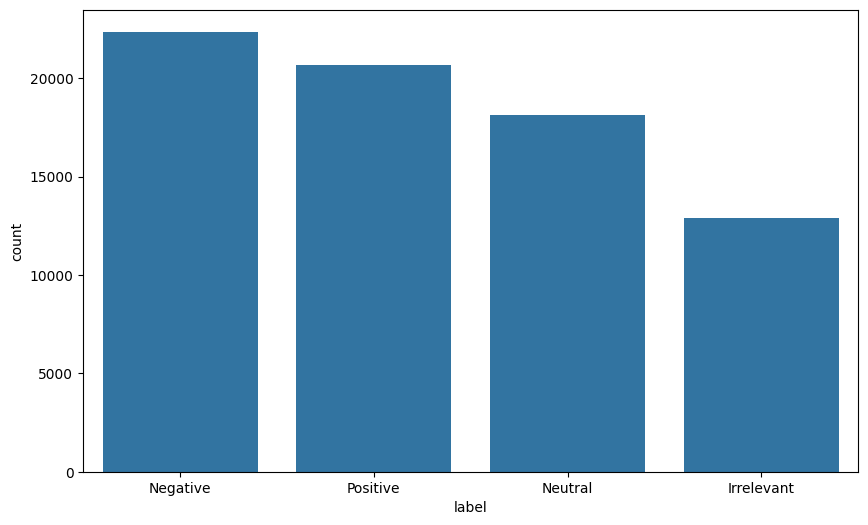

In [46]:
# plot label
plt.figure(figsize=(10,6))
sns.barplot(df['label'].value_counts())
plt.show()

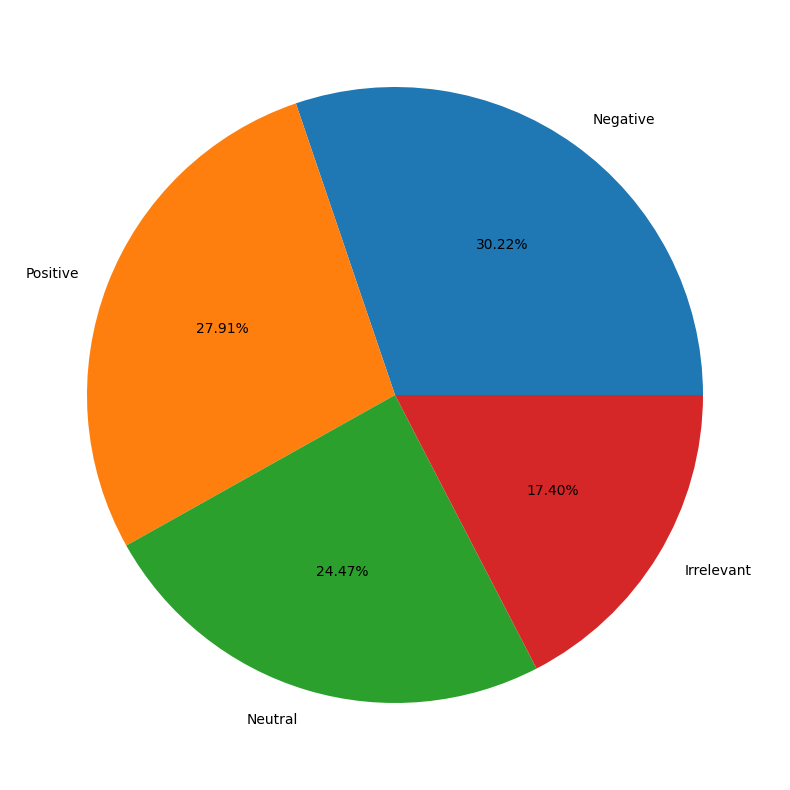

In [47]:
# plot labels values %
plt.figure(figsize=(10,10))
plt.pie(df['label'].value_counts(),labels=df['label'].value_counts().index,autopct='%1.2f%%')
plt.show()

In [48]:
# Data cleaning
def clearn_text(text):
  text = text.lower()
  text = re.sub(r'http\S+|www\S+|https\S+','',text)
  text = re.sub(r'\d+','',text)
  text = re.sub(r'\W+',' ',text)
  text = re.sub(r'\s+',' ',text)
  return text


In [49]:
df['tweets'] = df['tweets'].apply(clearn_text)
df['tweets']

,tweets
0,i am coming to the borders and i will kill you...
1,im getting on borderlands and i will kill you ...
2,im coming on borderlands and i will murder you...
3,im getting on borderlands and i will murder yo...
4,im getting into borderlands and i can murder y...
...,...
74676,just realized that the windows partition of my...
74677,just realized that my mac window partition is ...
74678,just realized the windows partition of my mac ...
74679,just realized between the windows partition of...


In [50]:
# sentiment labels
label_enc = LabelEncoder()
df['label'] = label_enc.fit_transform(df['label'])

In [51]:
# Text to sequence using TensorFlow
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweets'].values)
sequences = tokenizer.texts_to_sequences(df['tweets'].values)
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post', truncating='post')

In [52]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, df['label'].values, test_size=0.2, random_state=42)

In [53]:
# Create PyTorch dataset
class SentimentDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [54]:
train_dataset = SentimentDataset(X_train, y_train)
test_dataset = SentimentDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [55]:
# Define PyTorch model
class SentimentClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super(SentimentClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        out = self.dropout(hidden[-1])
        out = self.fc(out)
        return out


In [56]:
# Initialize and train model
model = SentimentClassifier(vocab_size=10000, embed_dim=128, hidden_dim=128, output_dim=len(label_enc.classes_))

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [57]:
print(len(label_enc.classes_))

4


In [58]:
# Training loop
for epoch in range(20):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 2508.2510
Epoch 2, Loss: 2475.4295
Epoch 3, Loss: 2396.7128
Epoch 4, Loss: 2227.4271
Epoch 5, Loss: 1964.2796
Epoch 6, Loss: 1758.1819
Epoch 7, Loss: 1603.8712
Epoch 8, Loss: 1388.1286
Epoch 9, Loss: 1252.6694
Epoch 10, Loss: 1095.0770
Epoch 11, Loss: 934.9757
Epoch 12, Loss: 805.6139
Epoch 13, Loss: 734.2714
Epoch 14, Loss: 602.2347
Epoch 15, Loss: 510.4913
Epoch 16, Loss: 442.7694
Epoch 17, Loss: 390.5617
Epoch 18, Loss: 347.8179
Epoch 19, Loss: 313.4255
Epoch 20, Loss: 289.4748


In [59]:
# Evaluate model
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()


accuracy = correct / total
print(f"Test Accuracy: {accuracy:.2f}")

# Trainig accuracy
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, targets in train_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()


accuracy = correct / total
print(f"Train Accuracy: {accuracy:.2f}")



Test Accuracy: 0.82
Train Accuracy: 0.96


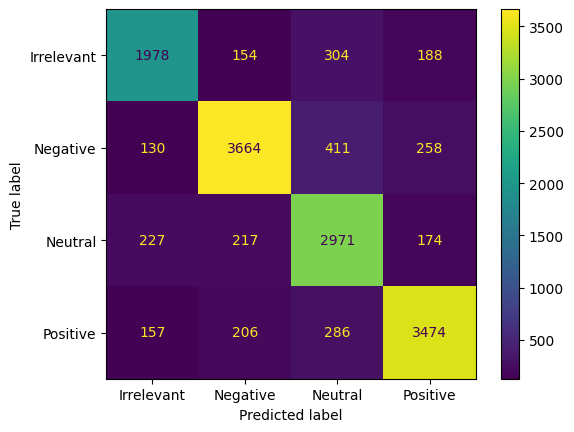

In [61]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_preds, all_targets = [], []
model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.numpy())
        all_targets.extend(targets.numpy())

cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=label_enc.classes_)
disp.plot()


In [66]:
def predict_sentiment(text):
    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=50, padding='post', truncating='post')
    input_tensor = torch.tensor(padded, dtype=torch.long)
    with torch.no_grad():
        output = model(input_tensor)
        pred = torch.argmax(output, dim=1).item()
        return label_enc.inverse_transform([pred])[0]

# Example
print(predict_sentiment("I love this product!"))


Positive


In [67]:
# Save PyTorch model
torch.save(model.state_dict(), 'sentiment_model.pth')

# Save label encoder
import joblib
joblib.dump(label_enc, 'label_encoder.pkl')

# Save tokenizer
import pickle
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
